# Natural Disaster Images Classification

**Author:** Ryan Reilly

![title](images/disaster_1.jpeg)

## Overview

This project analyzes almost 17,000 images related to natural disasters.  Human labelers labeled these images and then the images were into a downloadable format from the Crisis NLP website. Crisis NLP makes resources available to help researchers and technologists  advance research on humanitarian and crisis computing. I will be using the disaster type dataset. There were two original datasets that were collected for disaster types images:

1. Damage Multimodel Dataset (DMD). Method used to collect: crawled images from Google and Instagram based on 100 different hashtags related to crisis lexicon.

2. AIDR Disaster Type Dataset (AIDR-DT) Method used to collect: tweets were collected from 17 disaster events, and then using the annotations of the tweet, they crawled images from bing, google and flickr.  

The goal of this analysis is to build a model that will accurately predict the disaster type of the image scraped off the internet. This will be done through exploratory data analysis and iterative predictive modeling using classification models. 

## Business Problem

During a disaster event, images shared on social media helps government organizations gain situational awareness and assess incurred damages, among other response tasks. By classifying images of natural disasters, this model would aim to help organizations like FEMA augment data they are already receiving about a disaster. This would allow FEMA to disseminate more information down to crisis managers so the correct resources are deployed to the disater quicker, thus saving more lives. 

## Data Understanding

The data comes in two types of files. There is a folder of images and 3 tsv files that shows the path of each image for the train, validation, and test splits. The data was downloaded from this website: https://crisisnlp.qcri.org/crisis-image-datasets-asonam20. Below are the columns and their description of each tsv file. 

| Feature | Description|
|:-------| :-------|
|event_name| Name of original dataset used. Either AIDR or DMD|
|image_id| Unique ID for each image|
|image_path| Folder structure path of where the image is stored|
|class_label|Disaster type|

## Importing packages and loading the datasets

In [1]:
#For manipulating and visualizing images
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools

#To load an image using Keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers, models, applications
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

#to track how long the models run
import datetime

#For dividing the images into correct folders
import shutil
import os

#To utilize custom functions in .py file
import sys
sys.path.insert(0, 'src/')
import preprocessing

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the three tsv files 
train = pd.read_csv('data/consolidated_disaster_types_train_final.tsv', sep='\t')
validation = pd.read_csv('data/consolidated_disaster_types_dev_final.tsv', sep='\t')
test = pd.read_csv('data/consolidated_disaster_types_test_final.tsv', sep='\t')

In [3]:
#Take a look at the datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12846 entries, 0 to 12845
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   event_name   12846 non-null  object
 1   image_id     12846 non-null  object
 2   image_path   12846 non-null  object
 3   class_label  12846 non-null  object
dtypes: object(4)
memory usage: 401.6+ KB


#### Since the images are in a seperate folder, I have to divided them so I can successfully build a model using Keras. Below is a function I built that does just this. I have already ran the function, so these cells are commented out. You can reference how the function is built in the py file.  

In [4]:
# image_divider(data = train, split_type = 'train')
# image_divider(data = dev, split_type = 'dev')
# image_divider(data = test, split_type = 'test')

In [4]:
#Set working directories for each split
train_dir = '../data/train'
validation_dir = '../data/dev'
test_dir = '../data/test'

## EDA

#### How are the classes distributed across train, validation and test folders?

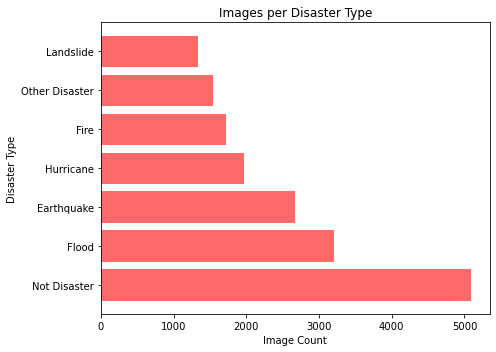

In [7]:
fig, ax = plt.subplots(figsize=(7, 5))

#We need to add all three value counts together
train_values = train['class_label'].value_counts().values
validation_values = validation['class_label'].value_counts().values
test_values = test['class_label'].value_counts().values

#Create x and y
x = ['Not Disaster','Flood','Earthquake','Hurricane','Fire','Other Disaster','Landslide']
y = train_values + validation_values + test_values

#Plot the barchart
ax.barh(x,y,color='#FE6A6A')

ax.set_xlabel('Image Count')
ax.set_ylabel('Disaster Type')
ax.set_title('Images per Disaster Type');
plt.tight_layout()
#save fig
fig.savefig('images/classes_count.png');

The chart above shows the count of images for each of the classes. There looks to be a good amount of training images for all 7 classes. However, there does look to be a class imbalance, especially with the Not Disaster images having considerably more images. I will deal with this by experimenting with adding weights to the CNN models I train. 

#### Are the disaster types distrubuted the same thorugh train, validation, and test folders?

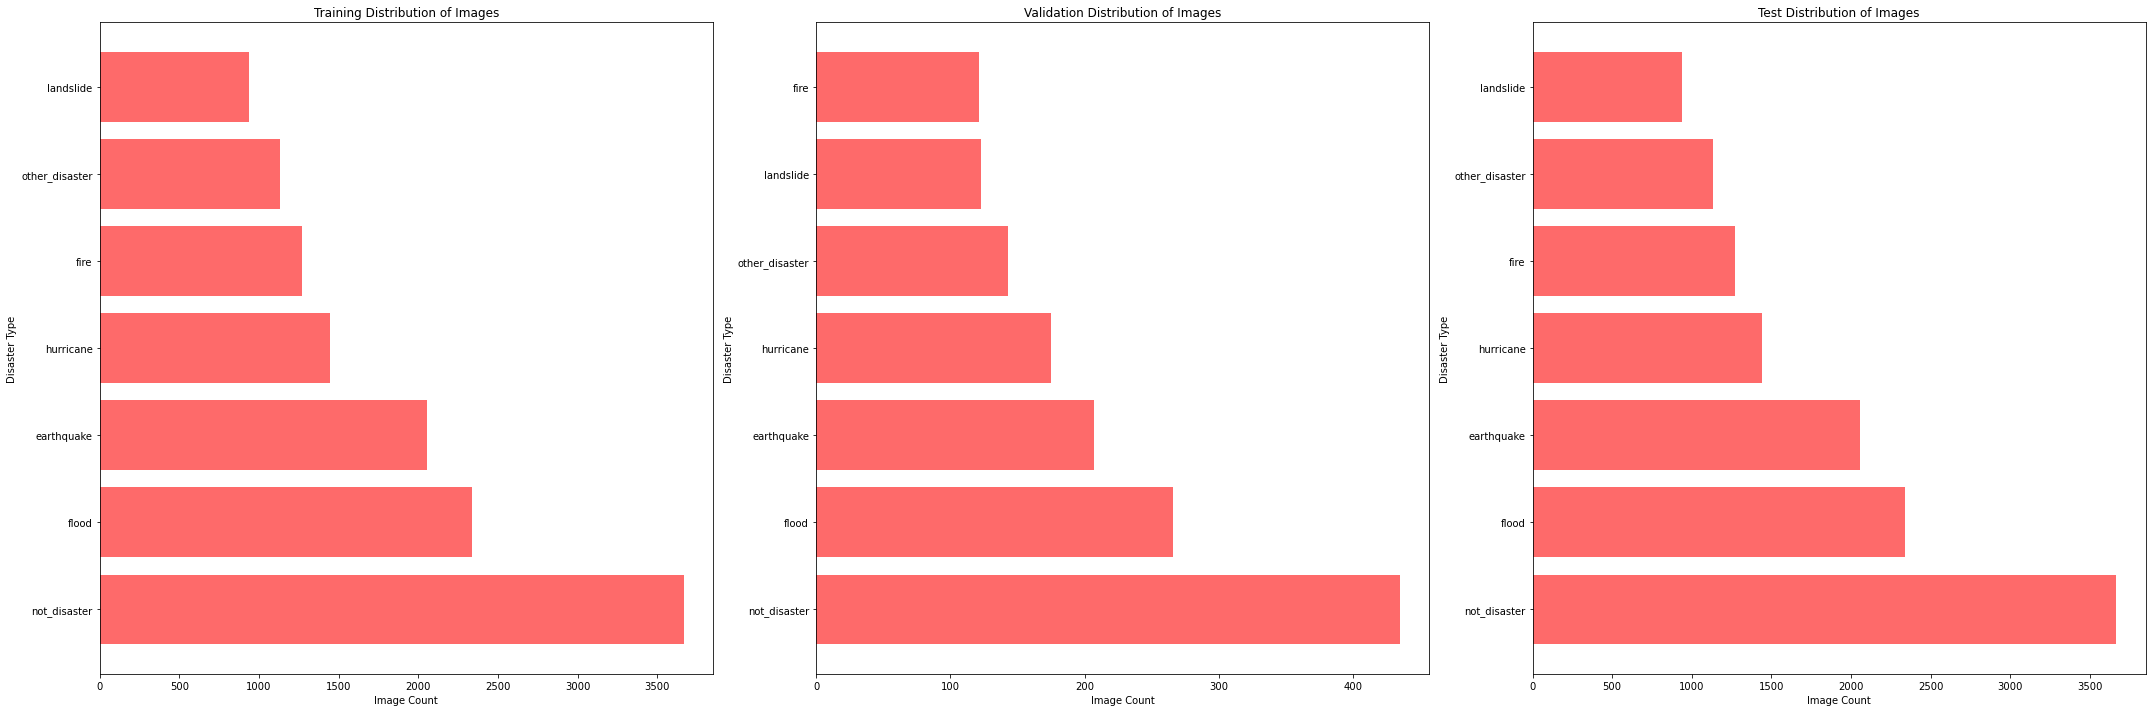

In [6]:
#Create a bar chart of the top 5 most profitable movies in the top 3 most profitable months

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (30,10))


#Train folder

x1 = train['class_label'].value_counts().index
y1 = train['class_label'].value_counts().values

ax1.barh(x1,y1,color='#FE6A6A')

ax1.set_title('Training Distribution of Images')
ax1.set_xlabel('Image Count')
ax1.set_ylabel('Disaster Type')


#Validation folder

x2 = validation['class_label'].value_counts().index
y2 = validation['class_label'].value_counts().values


ax2.barh(x2,y2,color='#FE6A6A')


ax2.set_title('Validation Distribution of Images')
ax2.set_xlabel('Image Count')
ax2.set_ylabel('Disaster Type')

#Test folder

x3 = train['class_label'].value_counts().index
y3 = train['class_label'].value_counts().values

ax3.barh(x3,y3,color='#FE6A6A')

ax3.set_title('Test Distribution of Images')
ax3.set_xlabel('Image Count')
ax3.set_ylabel('Disaster Type')

plt.tight_layout()
fig.savefig('images/distribution_splits.png');

I created the above charts just to visually inspect the images counts across each folder. The train, validation and test folders look to have the same distribution of images over each class. The train/validation/test splits for these images are 70/10/20 respectively.

#### What do sample images look like?

flood


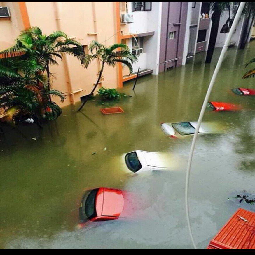

not_disaster


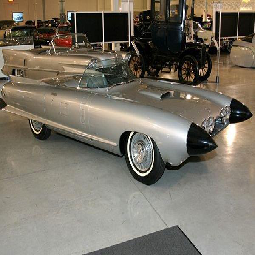

landslide


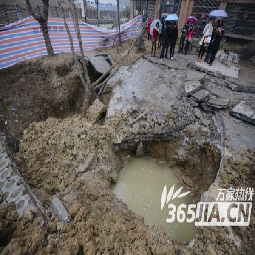

fire


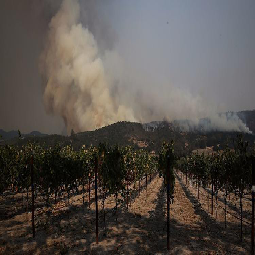

earthquake


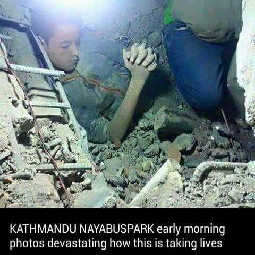

hurricane


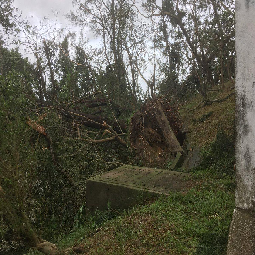

other_disaster


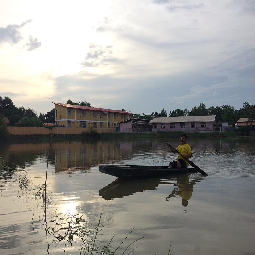

In [9]:
#loop through the folders and display the first image for each disasaster type
for dirname, _, filenames in os.walk(train_dir):
    for counter, filename in enumerate(filenames):
        if filename != '.DS_Store':
            print(dirname.split('/')[-1])
            image = os.path.join(dirname, filename)
            display(load_img(image, target_size = (255,255)))
        if counter == 0:
            break

Above you can see a sample image for each class from the train folder after it has been re-scaled. All the images came in a lot of different sizes but it is important to rescale to the same range between 0 and 1 because it will make images easier to work with during the modeling process. You can see there is a lot of noise in these images, which will make it even harder to train on, so I may need to take advantage of transfer learning. 

# Preprocessing (Scaling)

In [9]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
            
validation_datagen = ImageDataGenerator(rescale=1./255)

#create the train and validation generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(224, 224), 
                                                              batch_size=32, 
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 12422 images belonging to 7 classes.
Found 1458 images belonging to 7 classes.


In [10]:
#Check the shape of each image and label batch
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 7)


Now each image batch is 32 images by 224 pixels by 224 pixels by 3 (rgb). 

# Modeling

## First Simple Model - CNN

In [11]:
#Datetime used to calculate how long the model will run
original_start = datetime.datetime.now()
start = datetime.datetime.now()

#Build the model layers
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

#Compile the model
opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])


#Fit the model
history = model.fit_generator(train_generator,
                              steps_per_epoch=10,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=1) 

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
10/10 [==============================] - 34s 3s/step - loss: 3.4739 - acc: 0.2250 - val_loss: 1.9701 - val_acc: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 36s 4s/step - loss: 1.9307 - acc: 0.1625 - val_loss: 1.7861 - val_acc: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 36s 4s/step - loss: 1.8137 - acc: 0.2937 - val_loss: 2.0905 - val_acc: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 37s 4s/step - loss: 1.8523 - acc: 0.2531 - val_loss: 1.6964 - val_acc: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 38s 4s/step - loss: 1.8093 - acc: 0.2781 - val_loss: 1.6467 - val_acc: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 39s 4s/step - loss: 1.7765 - acc: 0.3094 - val_loss: 1.7214 - val_acc: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 38s 4s/step - loss: 1.7885 - acc: 0.3063 - val_loss: 1.7676 - val_acc: 0.0000e+00
Epoch 8/10
10/10 [==============================] - 39s 4s/ste

In [12]:
#View Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186624)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                11944000  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8

#### Plot the traing and validation loss and accuracy

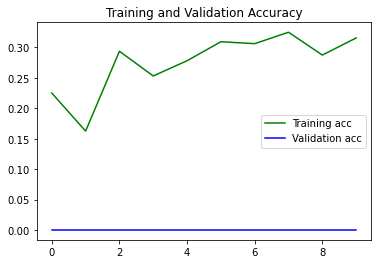

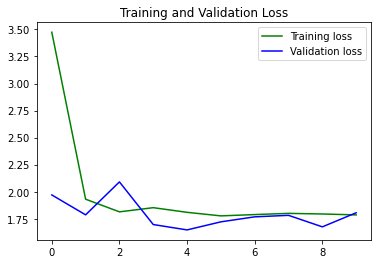

In [13]:
#Use the history parameters to plot accuracy and loss for training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

#Accuracy plot
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#Loss plot
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
#Create a test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(224, 224), 
                                                  batch_size=32, 
                                                  class_mode='categorical',
                                                  shuffle=False)
#Create predictions
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)


Found 3147 images belonging to 7 classes.


In [15]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


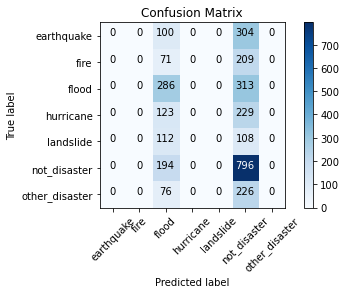

In [16]:
#Create a confusion matrix plot using the preprocessing src file. 
cm = confusion_matrix(test_generator.classes, y_pred)
#Create the labels
cm_plot_labels = [key for key,value in test_generator.class_indices.items()]
#plot
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [17]:
print(classification_report(test_generator.classes, y_pred, target_names = [key for key,value in test_generator.class_indices.items()]))

                precision    recall  f1-score   support

    earthquake       0.00      0.00      0.00       404
          fire       0.00      0.00      0.00       280
         flood       0.30      0.48      0.37       599
     hurricane       0.00      0.00      0.00       352
     landslide       0.00      0.00      0.00       220
  not_disaster       0.36      0.80      0.50       990
other_disaster       0.00      0.00      0.00       302

      accuracy                           0.34      3147
     macro avg       0.09      0.18      0.12      3147
  weighted avg       0.17      0.34      0.23      3147



#### This model did not do well. It basically predicted all to the majority class, not_disaster. With an accuracy score of 34, that is better than a random guess, but I think the model can be improved a lot. 

# 2nd Model 

**Changes Made from first model:** Added dropout layers to reduce overfitting, decreased learning rate from .001 to .0001, and added class weights to account for imbalanced classes. 

In [19]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

model_2 = models.Sequential()
model_2.add(Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 3)))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.5))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.5))
model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(7, activation='softmax'))

opt = optimizers.Adam(learning_rate=0.0001)
model_2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])



class_weights = {0: 0.86,
                 1: 1.39,
                 2: 0.75,
                 3: 1.22,
                 4: 3.43,
                 5: 0.48,
                 6: 1.56}


history_2 = model_2.fit_generator(train_generator,
                              steps_per_epoch=10,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=1,
                              class_weight = class_weights)

end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
10/10 [==============================] - 42s 4s/step - loss: 2.1103 - acc: 0.1375 - val_loss: 1.9050 - val_acc: 0.9688
Epoch 2/10
10/10 [==============================] - 44s 4s/step - loss: 1.8925 - acc: 0.2594 - val_loss: 1.9480 - val_acc: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 44s 4s/step - loss: 1.8121 - acc: 0.2969 - val_loss: 1.9484 - val_acc: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 46s 5s/step - loss: 1.9068 - acc: 0.2969 - val_loss: 1.9484 - val_acc: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 48s 5s/step - loss: 1.9084 - acc: 0.2969 - val_loss: 1.9485 - val_acc: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 49s 5s/step - loss: 1.8976 - acc: 0.2875 - val_loss: 1.9482 - val_acc: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 48s 5s/step - loss: 1.9082 - acc: 0.2750 - val_loss: 1.9477 - val_acc: 0.0000e+00
Epoch 8/10
10/10 [==============================] - 48s 5s/step - 

In [20]:
#View Model summary
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 186624)           

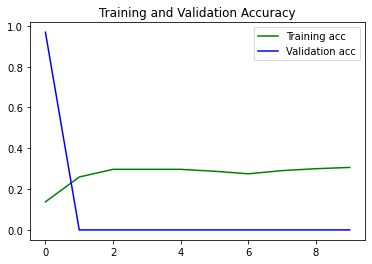

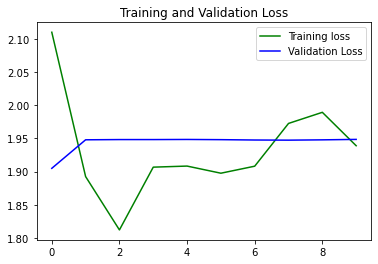

In [22]:
#Use the history parameters to plot accuracy and loss for training and validation
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(len(acc))

#Accuracy plot
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
#Loss plot
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [23]:
#Make Predictions
y_pred2 = model_2.predict(test_generator)
y_pred2 = np.argmax(y_pred2, axis=1)

In [ ]:
## Create a confusion matrix plot using the preprocessing src file. 
cm = confusion_matrix(test_generator.classes, y_pred2)
#Create the labels
cm_plot_labels = [key for key,value in test_generator.class_indices.items()]
#plot
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [25]:
print(classification_report(test_generator.classes, y_pred2, target_names = [key for key,value in test_generator.class_indices.items()]))

                precision    recall  f1-score   support

    earthquake       0.00      0.00      0.00       404
          fire       0.00      0.00      0.00       280
         flood       0.00      0.00      0.00       599
     hurricane       0.00      0.00      0.00       352
     landslide       0.00      0.00      0.00       220
  not_disaster       0.31      1.00      0.48       990
other_disaster       0.00      0.00      0.00       302

      accuracy                           0.31      3147
     macro avg       0.04      0.14      0.07      3147
  weighted avg       0.10      0.31      0.15      3147



#### It looks like the accuracy got even worse while the training time increased. I'm not sure why it predicted flood every time. I will move on to try transfer learning.  At this point I did not want to run any more models on my machine because they were taking too long to train. I decided to get a Google Colab Pro account which aloud me to access cloud GPUs with 32GB of ram compared to the 8GB of ram on my computer. The below three models were run with Colab and saved in the "transfer_learning_models" folder in the repo if you wan to see the code behind them. 

# 3rd Model - Transfer Learning - VGG16

Please reference the vgg model in the **transfer_learning_models** folder to see the code for this model that was built in Google Colab. The confusion matrix and classification report below are the results of predicting on the test data.

![title](images/vgg_training_loss.png)

The training and validation accuracy and loss look a lot better than the first couple models. The validation accuracy is considerably higher than the training accuaracy and i think that has to do with using dropout layers because regularization models such as Dropout are turned off during testing. I set Dropout = 0.5 which means 50% of features will be 0 during training. However, during validation all features are used, so the model is more robust and have better validation accuracy.

![title](images/vgg_confusion.png)

The confusion matrix also looks a lot better than our first couple models. The model does a good job of predicting not_disaster, flood and earthquake. It has a more difficult time predicting other disaster landslide, and fire. 

![title](images/vgg_classification_report.png)

Above you can see the classification report for the vgg model with an overall accuracy of 56%. This is a lot better than the baseline CNN model, but there is still room for improvement. 

# 4th Model - Transfer Learning - ResNet50

Please reference the resnet_model in the **transfer_learning_models** folder to see the code for this model that was built in Google Colab. The confusion matrix and classification report below are the results of predicting on the test data.

![title](images/resnet_training_loss.png)

The validation accuracy and loss looks to have fluctuated a lot while the training accuracy and loss looked pretty smooth, but the accuracy was not as high as the VGG16 model. 

![title](images/resnet_confusion.png)

One again, the model did a good job of predicting the class with the highest amount of images, but did not do a very good job of predicting some of the other classes. 

![title](images/resnet_classification_report.png)

The overall accuracy did okay at around 46, but not as good as the VGG16 model. I will try one other transfer learning model, DenseNet121. 

# Final Model- Transfer Learning - DenseNet121

Please reference the dense_model in the **transfer_learning_models** folder to see the code for this model that was built in Google Colab. The confusion matrix and classification report below are the results of predicting on the test data.

![title](images/dense_training_loss.png)

The accuracy and loss curves have the same shape as the vgg model. I also used dropout of .5 in this model as a regularization technigue. I also used batch normalization in this model which made the model more stable during training.

![title](images/dense_confusion.png)

You can see from the confusion matrix that the model did a good job at predicting all of the classes.

![title](images/dense_classification_report.png)

By far this model performed the best on the testing data, with an accuracy of 72%! 

# Conclusions

**Transfer learning performs better.** By using models that have been pre trained on millions of images, it not only speeds up the compute time, but accuracy improves considerably over a baseline CNN model built from scratch. 

**Consider using the final model in real applications** I showed in the demonstration that this model coulsd be used to predict images that are scraped from twitter by users who upload phots of natural disasters as they happen so FEMA can augment data they are receiving about the disaster. 

**Consider other use cases**This model would work well with other forms of social media, not just twitter, like I showed. Any place where users are uploading photos of disasters is a good place to classify the image to get more information. 

# Next Steps

**Incorporate real time image scraping** While I can upload an image manually, it would be nice to autamate the app to scrape twitter at various intervals throughout the day and automatically detect natrual disasters quicker. 

**Perform more tasks on the images** This can be done by classifying images as informative/not informative, and classify severity as severe, mild, or little to none.

**Implement other cloud based modeling** I would like to run these models using even more GPUs on other cloud providers to see if I can speed up training on the larger models.

**Gather more images** There were a good amount of images for this project, but it would be nice to get even more unique images. Natural disasters happen every year, so it would be nice to update the model with pictures of more recent natural disasters.  